based on: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('../data/names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
block_size = 3
x,y = list(),list()
for word in words:
    context=[0]*block_size
    # context is the vector representation
    for character in word+'.':
        ix = stoi[character]
        x.append(context)
        y.append(ix)
        # print(''.join(itos[i] for i in context),'--->',character)
        context = context[1:] + [ix]
X = torch.tensor(x)
Y = torch.tensor(y)

In [109]:
X.shape

torch.Size([228146, 3])

# 1.

## 1.1: Building lookup table
- converting 27 characters into 2d space

In [79]:
generator = torch.Generator().manual_seed(2147483647)
lookup_table = torch.randn((27,2),generator=generator,requires_grad=True)
embedding = lookup_table[X]

In [80]:
embedding.shape

torch.Size([32, 3, 2])

## 1.2 Forward Pass

In [147]:
W1 = torch.randn((6,100),generator=generator,requires_grad=True)
b1 = torch.randn(100,generator=generator,requires_grad=True)
W2 = torch.randn((100,27),generator=generator,requires_grad=True)
b2 = torch.randn(27,generator=generator,requires_grad=True)
parameters = [lookup_table,W1,b1,W2,b2]

In [82]:
h = torch.tanh(embedding.view(-1,6) @ W1 + b1)
h.shape
logits = torch.tanh(h @ W2+b2)
loss = F.cross_entropy(logits,Y)

## 1.3: Backward Pass

In [ ]:
for p in parameters:
    p.grad=None
loss.backward()
for p in parameters:
    p.data += -0.01 * p.grad

## 1.4: All together

In [23]:
lr_exp = torch.linspace(-3,0,1000)
lrs = 10**lr_exp

In [95]:
generator = torch.Generator().manual_seed(2147483647)
lookup_table = torch.randn((27,10),generator=generator,requires_grad=True)
W1 = torch.randn((30,200),generator=generator,requires_grad=True)
b1 = torch.randn(200,generator=generator,requires_grad=True)
W2 = torch.randn((200,27),generator=generator,requires_grad=True)
b2 = torch.randn(27,generator=generator,requires_grad=True)
parameters = [lookup_table,W1,b1,W2,b2]
print(f'Total no. of elements: {sum(p.nelement() for p in parameters)}')
losses = list()
lr_i = list()
for i in range(30000):
    ix = torch.randint(0,X.shape[0],(32,))
    embedding = lookup_table[X[ix]]
    h = torch.tanh(embedding.view(-1,30) @ W1 + b1)
    logits = torch.tanh(h @ W2+b2)
    loss = F.cross_entropy(logits,Y[ix])
    losses.append(loss.item())
    if i%1000 == 0:
        print(f'{i=} loss={loss.item():.4f}')
    for p in parameters:
        p.grad=None
    loss.backward()
    for p in parameters:
        p.data +=-1* p.grad
print(f'Average loss = {loss.item ()}')

Total no. of elements: 11897
i=0 loss=3.6458
i=1000 loss=2.9257
i=2000 loss=2.8322
i=3000 loss=2.5411
i=4000 loss=2.8209
i=5000 loss=2.7255
i=6000 loss=3.0010
i=7000 loss=2.9826
i=8000 loss=2.7275
i=9000 loss=2.7526
i=10000 loss=2.4507
i=11000 loss=2.5328
i=12000 loss=2.4642
i=13000 loss=2.7370
i=14000 loss=3.0548
i=15000 loss=2.6631
i=16000 loss=2.5656
i=17000 loss=2.4928
i=18000 loss=2.7555
i=19000 loss=2.5999
i=20000 loss=2.7768
i=21000 loss=2.9174
i=22000 loss=2.2337
i=23000 loss=2.8095
i=24000 loss=2.7853
i=25000 loss=2.7593
i=26000 loss=2.4551
i=27000 loss=2.9646
i=28000 loss=2.6706
i=29000 loss=2.7946
Average loss = 2.645737409591675


In [87]:
embedding = lookup_table[X]
h = torch.tanh(embedding.view(-1,6) @ W1 + b1)
logits = torch.tanh(h @ W2+b2)
loss = F.cross_entropy(logits,Y)
loss

tensor(2.7127, grad_fn=<NllLossBackward0>)

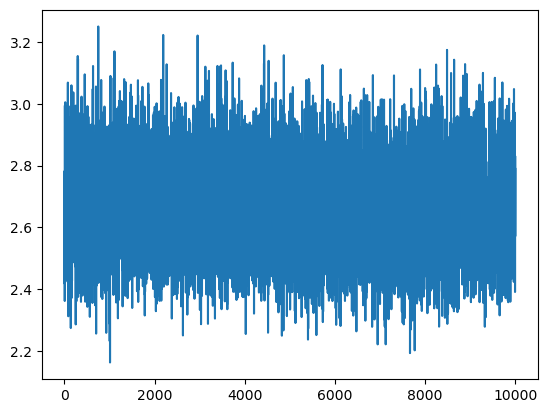

In [43]:
plt.plot(losses)

tensor(2.6803, grad_fn=<NllLossBackward0>)

In [146]:
W1[:,0]

tensor([ 0.6118,  0.2990,  0.2103, -0.2308, -0.5327,  0.3144],
       grad_fn=<SelectBackward0>)

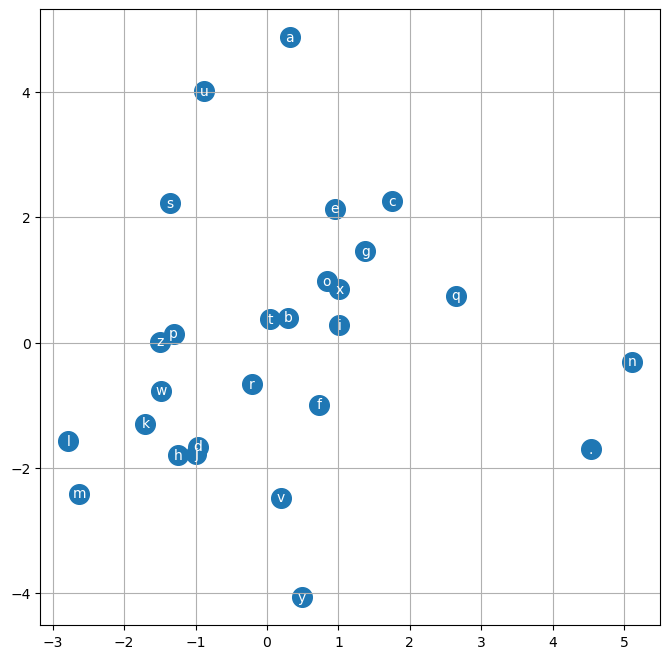

In [97]:
plt. figure(figsize=(8,8))
plt.scatter(lookup_table[:,0].data, lookup_table[:,1] .data, s=200)
for i in range(lookup_table.shape[0]):
    plt.text(lookup_table[i,0]. item(), lookup_table[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid ('minor')

# 2. Final Neural Network
- After i completed this implementation the names i got were carlah, amille, khi, mili, taty, salayskenrahnee, dellah, jareei, nellara, chaiir, kaleigh, ham, jois, quinthonlee, alian, quinzelogiearynn, jaceelinsley, dae, iia, gian. Which are not bad at all.
- I got a train, dev and test loss of 2.1201 ,2.1678 ,2.1719
The hyperparameters i used were:
    - lookup table size : (27,10)
    - input layer size : (30,200) -> 30 because we're giving it essentially 3 words of 10 "characters" each (characters are columns)
    - output layer size : (200, 27)
    - learning rate : 0.1 for <100000 iterations and 0.01 for >100000 iterations
    - iterations : 200000
    

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open('../data/names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
def build_dataset(words):
    block_size = 3
    x,y = list(),list()
    for word in words:
        context=[0]*block_size
        # context is the vector representation
        for character in word+'.':
            ix = stoi[character]
            x.append(context)
            y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',character)
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    return X,Y

In [5]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train_X,train_Y = build_dataset(words[:n1])
dev_X,dev_Y = build_dataset(words[n1:n2])
test_X,test_Y = build_dataset(words[n2:])

In [6]:
torch.manual_seed(2147483647)
generator = torch.Generator()
lookup_table = torch.randn((27,10),generator=generator,requires_grad=True)
W1 = torch.randn((30,200),generator=generator,requires_grad=True)
b1 = torch.randn((200),generator=generator,requires_grad=True)
W2 = torch.randn((200,27),generator=generator,requires_grad=True)
b2 = torch.randn((27),generator=generator,requires_grad=True)
parameters=[lookup_table,W1,b1,W2,b2]
print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

Total number of parameters: 11897


0.01 didn't decrease loss as much <br>
0.1 decreases it pretty fast <br>
10 sucks <br>

In [7]:
lr_exp = torch.linspace(-2,0,1000)
lrs = 10**lr_exp

In [8]:
losses = list()
step_i = list()
lr_i = list()

In [9]:
for i in range(200000):
    ix = torch.randint(0,train_X.shape[0],(32,))
    embedding = lookup_table[train_X[ix]]
    h = torch.tanh(embedding.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, train_Y[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    # lr_i.append(lr_exp[i])
    if i< 100000:lr=0.1 
    else:lr=0.01
    for p in parameters:
        p.data += -lr * p.grad
    step_i.append(i)
    if i%10000 == 0:
        print(f"{i=} Loss={loss.item():.4f}")
    losses.append(loss.item())

i=0 Loss=29.3241
i=10000 Loss=2.2348
i=20000 Loss=2.5184
i=30000 Loss=2.3840
i=40000 Loss=2.0605
i=50000 Loss=2.6135
i=60000 Loss=2.1891
i=70000 Loss=1.9650
i=80000 Loss=2.1965
i=90000 Loss=2.1252
i=100000 Loss=2.2667
i=110000 Loss=2.1693
i=120000 Loss=2.3404
i=130000 Loss=1.7430
i=140000 Loss=2.1688
i=150000 Loss=2.2705
i=160000 Loss=2.1065
i=170000 Loss=1.7547
i=180000 Loss=2.6303
i=190000 Loss=2.3582


In [10]:
embedding = lookup_table[train_X]
h = torch.tanh(embedding.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, train_Y)

embedding = lookup_table[test_X]
h = torch.tanh(embedding.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
test_loss = F.cross_entropy(logits, test_Y)

embedding = lookup_table[dev_X]
h = torch.tanh(embedding.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, dev_Y)
print(f"train_loss={train_loss.item():.4f} \ndev_loss={dev_loss.item():.4f} \ntest_loss={test_loss.item():.4f}")


train_loss=2.1258 
dev_loss=2.1623 
test_loss=2.1580


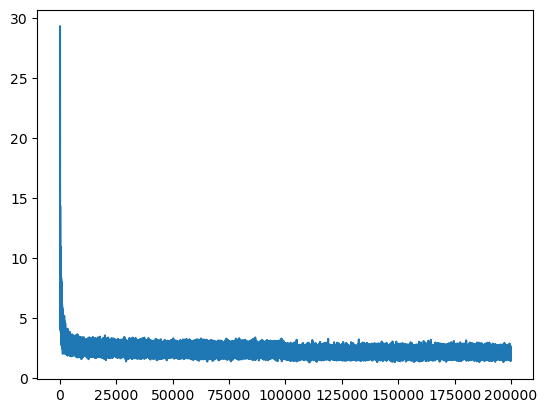

In [11]:
plt.plot(step_i,losses)

In [156]:
# Sampling:
generator_inference = torch.Generator().manual_seed(2147483647 + 10)
block_size=3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embedding_sample = lookup_table[torch.tensor([context])]
        h = torch.tanh(embedding_sample.view(1,-1)@W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,replacement=True,generator=generator_inference).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

carlah
amille
khi
mili
taty
salayskenrahnee
dellah
jareei
nellara
chaiir
kaleigh
ham
jois
quinthonlee
alian
quinzelogiearynn
jaceelinsley
dae
iia
gian
